# Ridge regression using grid search CV 
The following code is highly inspired by "https://github.com/fnauman/timeseries/blob/master/candydata/xgboost_pipeline_candy.ipynb" but modified to fit our data. The times series handling and use of TimeSeriesSplit is confirmed by https://github.com/carl24k/fight-churn.


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [118]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-8): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [119]:
# Load in the time series
candy = pd.read_csv('dfV3.csv')
# Set the index equal to time stamp
candy["Unnamed: 0"] = pd.to_datetime(candy["Unnamed: 0"])
candy = candy.set_index('Unnamed: 0')


In [120]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(figsize = (20,5))
# sns.color_palette("vlag", as_cmap=True)
# sns.set(font_scale = 0.5)
# candy["negDK2"] = -candy["DK2"]
# sns.heatmap(pd.DataFrame(candy.corr()["DK2"]).sort_values(by = "DK2", ascending = False).T, fmt="g", cmap='vlag')

# plt.show()

In [121]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-9341], candy.iloc[-9341:]

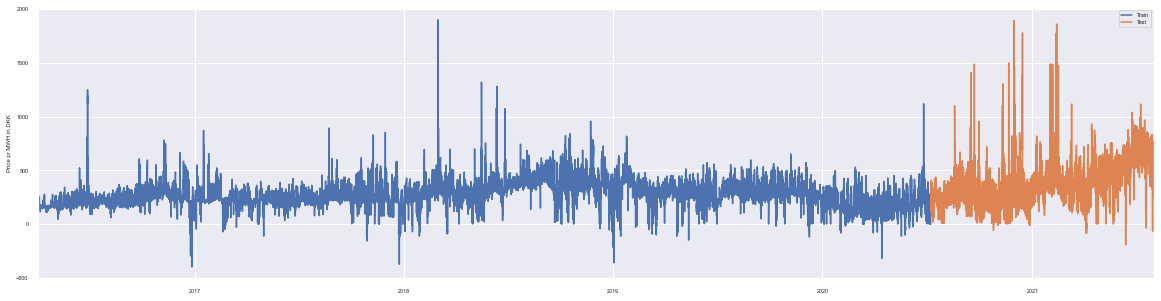

In [122]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots(figsize = (20,5))

# Plot the train and test setsa dn show
df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
ax.set_xlabel("")
ax.set_ylabel("Price pr MWH in DKK")
plt.show()

In [123]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK2', inplace=True, axis=1)
X_test.drop('DK2', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [124]:
# Define the pipeline for the Lasso regression
pipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_ridge = {'ridge__alpha': np.logspace(-4,10,40)}

In [125]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=40).split(X_train)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_ridge = GridSearchCV(pipe_ridge,
                        param_grid=params_ridge,
                        scoring='neg_mean_absolute_error',
                        cv=ts_cv,
                        n_jobs=4)

In [126]:
# Show which observations that go into train and validation sets
# ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
# for train_index, test_index in ts_cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)


In [127]:
# Using the defined pipeline to fit our training set
gs_ridge.fit(X_train,y_train)
# And predicting using the LASSO regression model and the test data 
y_pred_ridge = gs_ridge.predict(X_test)

<ipython-input-128-5e9e273b0d25>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_ridge


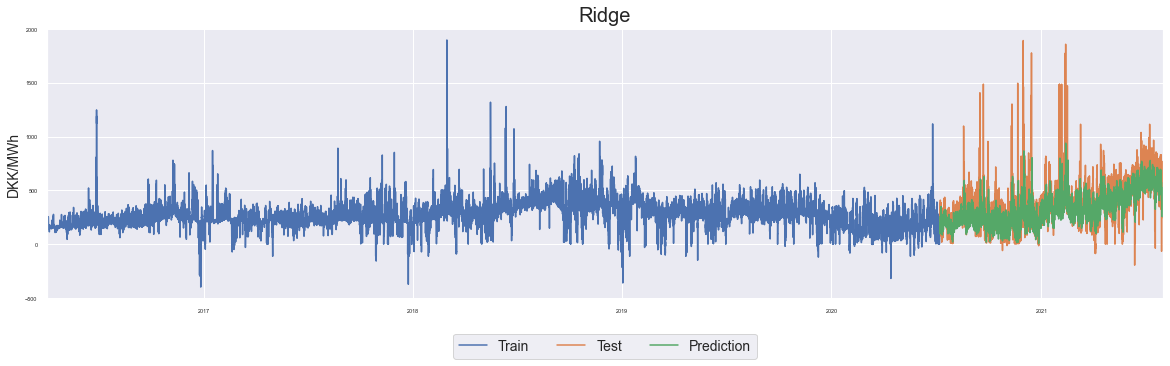

In [128]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (20,5))

df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)

df_test["pred"] = y_pred_ridge
df_test["pred"].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("DKK/MWh", fontsize = 14)
ax.set_title("Ridge", fontsize = 20)
ax.legend(["Train","Test","Prediction"],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=3, fontsize = 14);

# ax.legend(["Train","Test","Prediction"]);
plt.show()

In [129]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value in ridge using grid search: {gs_ridge.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_ridge)

Optimal lambda value in ridge using grid search: {'ridge__alpha': 1511.775070615663}
R2 score: 0.6863739705414319
MSE score: 12288.331498938398
MAE score: 72.46808174891734
Median AE score: 53.380811448557324
MAPE score: inf
SMAPE score: 13.520040804894833


<ipython-input-118-8fecfd3bbe5b>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


In [130]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge(alpha = gs_ridge.best_params_["ridge__alpha"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_ridge.fit(X_train,y_train)
finalpipe_ridge.predict(X_test)

array([[162.0591565 ],
       [155.27030497],
       [147.57119344],
       ...,
       [499.42858063],
       [474.76741733],
       [461.268689  ]])

In [131]:
# Save coefficients to a dictionary
candy.drop("DK2", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_ridge.named_steps['ridge'].coef_.T)[i][0]


In [132]:
d

{'cloud_cover': -0.31131329926645446,
 'temp_soil_max_past1h': 20.41327466335232,
 'wind_max_per10min_past1h': -3.004168014584712,
 'acc_precip': -1.0781949374137747,
 'bright_sunshine': 1.6000826237268995,
 'mean_pressure': 1.3295753948935953,
 'mean_radiation': -8.205940186615651,
 'mean_relative_hum': -3.013902543532419,
 'mean_temp': -0.14262528129263022,
 'mean_wind_dir': -0.3329229143383655,
 'mean_wind_speed': -2.278923133427138,
 'temp_grass': -2.53056518943611,
 'DK1_CP': 22.879212750638708,
 'DK2_CP': 10.918034888304906,
 'DK1_PP': 14.303156064085766,
 'DK2_PP': 13.51620937845424,
 'DK1_WP': -17.045516074503364,
 'DK2_WP': -16.927557113737805,
 'hour_1': 1.159771350190037,
 'hour_2': 0.868898288479367,
 'hour_3': 0.3718932831555237,
 'hour_4': -0.16307681151883138,
 'hour_5': -0.30361482596315403,
 'hour_6': 0.24850915578934274,
 'hour_7': 1.3164310485733752,
 'hour_8': 2.677716172629774,
 'hour_9': 2.329933932257732,
 'hour_10': 0.06968201921874892,
 'hour_11': -1.5257628905